- Start with general stuff

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import h5py, os
from tqdm import tqdm

In [2]:
def bin_y_over_x(x, y, x_bins):
    
    # Apply binning based on histogram function
    x_nu = np.append(x_bins, 2*x_bins[-1]-x_bins[-2])
    x_nu = x_nu - (x_nu[1] - x_nu[0])/2
        # Instead of N_x, gives fixed axis.
        # Solves issues with wider ranges, than covered by data
    _count, _ = np.histogram(x,
                             bins = x_nu,
                             weights=None)
    _count = np.array(_count, dtype='float64')
    _count[_count==0] = np.nan

    _sum, _ = np.histogram(x,
                           bins = x_nu,
                           weights = y)    
    return _sum/_count

- Get the gap

In [73]:
path = os.getcwd()
file = h5py.File(f'{path}/../23 11 15 PR22e9 0.025G/23_11_15_S22_tunneljuntion_0.025G0_1.hdf5', 'r')
list(file['measurement'].keys())

['single IV_+0.00mT_nanGHz_+nandBm']

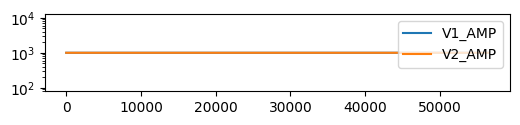

In [81]:
%matplotlib inline
plt.figure(figsize=(6,1))
plt.semilogy(file["status"]["femtos"]["amp_A"], label='V1_AMP')
plt.semilogy(file["status"]["femtos"]["amp_B"], label='V2_AMP')
plt.legend()

V1_AMP = 1000
V2_AMP = 10000
R_REF = 53000

In [75]:
mkey = "single IV_+0.00mT_nanGHz_+nandBm"

offset= file['measurement'][mkey]["offset"]["adwin"]

off_v1 = np.nanmean(offset["V1"])
off_v2 = np.nanmean(offset["V2"])
sweep = file['measurement'][mkey]["sweep"]["adwin"]

trigger = np.array(sweep['trigger'], dtype='int')
v1 = np.array(sweep['V1'], dtype='float64')
v2 = np.array(sweep['V2'], dtype='float64')

v_raw = (v1 - off_v1) / V1_AMP
i_raw = (v2 - off_v2) / V2_AMP / R_REF

v_raw_up = v_raw[trigger==1]
v_raw_down = v_raw[trigger==2]

i_raw_up = i_raw[trigger==1]
i_raw_down = i_raw[trigger==2]

V_raw = np.linspace(-6*191e-6, 6*191e-6, 360+1)

I_raw_up = bin_y_over_x(v_raw_up, i_raw_up, V_raw)
I_raw_down = bin_y_over_x(v_raw_down, i_raw_down, V_raw)

dIdV_raw_up= np.gradient(I_raw_up, V_raw)
dIdV_raw_down= np.gradient(I_raw_down, V_raw)

Text(0, 0.5, 'd$I/$d$V\\ (G_0)$')

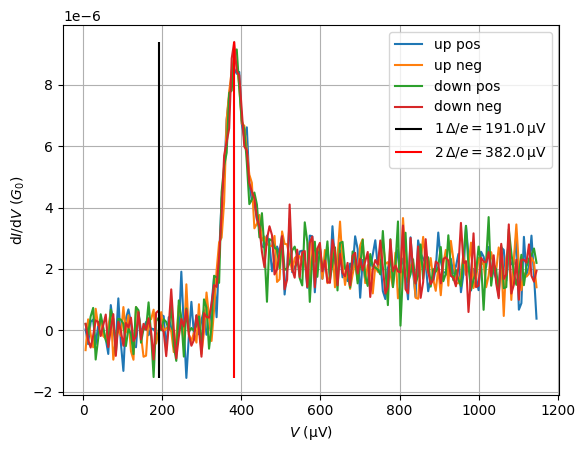

In [76]:
%matplotlib inline
plt.close(3)
plt.figure(3)

Vgap = 191e-6

V_raw_pos = np.copy(V_raw)
V_raw_pos[V_raw_pos<=0]=np.nan
V_raw_neg = np.copy(V_raw)
V_raw_neg[V_raw_neg>=0]=np.nan

plt.plot(V_raw_pos*1e6, dIdV_raw_up, label='up pos')
plt.plot(-V_raw_neg*1e6, dIdV_raw_up, label='up neg')
plt.plot(V_raw_pos*1e6, dIdV_raw_down, label='down pos')
plt.plot(-V_raw_neg*1e6, dIdV_raw_down, label='down neg')

minmax = [min([min(dIdV_raw_up), min(dIdV_raw_down)]), max([max(dIdV_raw_up), max(dIdV_raw_down)])]

plt.vlines(Vgap*1e6, ymin=minmax[0], ymax=minmax[1], color='k', label=fr'$1\,\Delta/e = {Vgap*1e6:.1f}\,$µV')
plt.vlines(2*Vgap*1e6, ymin=minmax[0], ymax=minmax[1], color='red', label=fr'$2\,\Delta/e = {2*Vgap*1e6:.1f}\,$µV')
# plt.vlines(2/3*Vgap, ymin=minmax[0], ymax=minmax[1], color='blue', label=fr'$2/3\,\Delta/e = {2/3*Vgap*1e6:.1f}\,$µV')
# plt.vlines(1/2*Vgap, ymin=minmax[0], ymax=minmax[1], color='grey', label=fr'$1/2\,\Delta/e = {1/2*Vgap*1e6:.1f}\,$µV')
# plt.vlines(3/2*Vgap, ymin=minmax[0], ymax=minmax[1], color='green', label=fr'$1/2\,\Delta/e = {3/2*Vgap*1e6:.1f}\,$µV')
plt.grid()
plt.legend()
plt.xlabel(r'$V\ ($µV$)$')
plt.ylabel(r'd$I/$d$V\ (G_0)$')

- define constants

In [198]:
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
Vgap = 191e-6       # V
Delta = Vgap*e      # V * A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A

- get theoretical IV curves from Carlos

In [199]:
arr = os.listdir('CarlosIV')
arr.remove('iv.in')
arr.remove('iv.for')

Transmission = np.zeros(len(arr), dtype='float64')

I_norm_theo = np.zeros((len(Transmission), len(V_norm)), dtype='float64')

for i in range(len(arr)):
    temp = arr[i][:-4]
    value = int(temp)*10**(-len(temp)+1)
    Transmission[i] = value

for i, a in enumerate(arr):
    v_norm_theo = np.genfromtxt(f'CarlosIV/{a}')[:,0]
    i_norm_theo = np.genfromtxt(f'CarlosIV/{a}')[:,1]
    I_norm_theo[i,:] = bin_y_over_x(v_norm_theo, i_norm_theo, V_norm)
dIdV_norm_theo = np.gradient(I_norm_theo, V_norm, axis=1)

Text(0, 0.5, 'd$I/$d$V\\ (G_0)$')

<Figure size 640x480 with 0 Axes>

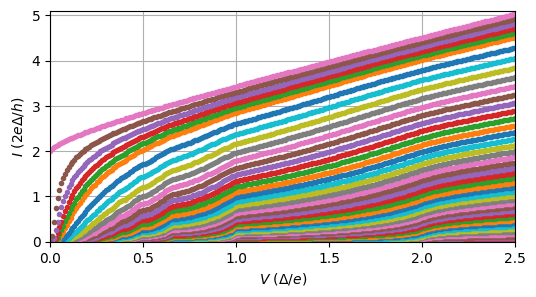

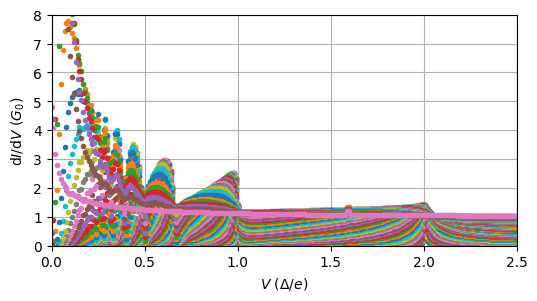

In [200]:
%matplotlib inline
plt.figure(1)
plt.figure(figsize=(6,3))
for i, T in enumerate(Transmission):
    plt.plot(V_norm, I_norm_theo[i,:], '.',label=f'{T:0.03}')
plt.grid()
plt.xlim(0,2.5)
plt.ylim(0,5.1)
plt.xlabel(r'$V\ (\Delta/e)$')
plt.ylabel(r'$I\ (2e\Delta/h)$')

plt.figure(2)
plt.figure(figsize=(6,3))
for i, T in enumerate(Transmission):
    plt.plot(V_norm, dIdV_norm_theo[i,:], '.',label=f'{T:0.03}')
plt.grid()
plt.xlim(0,2.5)
plt.ylim(0,8)
plt.xlabel(r'$V\ (\Delta/e)$')
plt.ylabel(r'd$I/$d$V\ (G_0)$')

- Get coefficients in 1.2G0

In [201]:
path = os.getcwd()
file = h5py.File(f'{path}/../23 11 10 PR22e9 1.2G0/23_11_10_1.2G_0.hdf5', 'r')
# list(file['measurement'].keys())

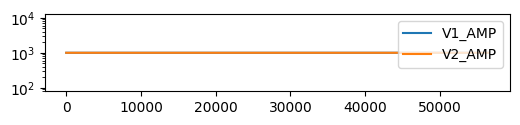

In [202]:
%matplotlib inline
plt.figure(figsize=(6,1))
plt.semilogy(file["status"]["femtos"]["amp_A"], label='V1_AMP')
plt.semilogy(file["status"]["femtos"]["amp_B"], label='V2_AMP')
plt.legend()

V1_AMP = 1000
V2_AMP = 1000
R_REF = 53000

In [203]:
mkey = "magnetic fields_nanGHz_+nandBm"
to_pop = "no_field"

offset= file['measurement'][mkey][to_pop]["offset"]["adwin"]

off_v1 = np.nanmean(offset["V1"])
off_v2 = np.nanmean(offset["V2"])
sweep = file['measurement'][mkey][to_pop]["sweep"]["adwin"]

trigger = np.array(sweep['trigger'], dtype='int')
v1 = np.array(sweep['V1'], dtype='float64')
v2 = np.array(sweep['V2'], dtype='float64')

v1_up   = v1[trigger==1]
v1_down = v1[trigger==2]
v2_up   = v2[trigger==1]
v2_down = v2[trigger==2]

v_raw_up   = (v1_up   - off_v1) / V1_AMP
v_raw_down = (v1_down - off_v1) / V1_AMP
i_raw_up   = (v2_up   - off_v2) / V2_AMP / R_REF
i_raw_down = (v2_down - off_v2) / V2_AMP / R_REF

v_norm_up   = v_raw_up   / Vgap
v_norm_down = v_raw_down / Vgap
i_norm_up   = i_raw_up   / ( 2 * e * Delta / h)
i_norm_down = i_raw_down / ( 2 * e * Delta / h)

V_raw  = np.concatenate((-np.flip(V_norm)[:-1], V_norm)) * Vgap

I_norm_up_pos   =  bin_y_over_x(v_norm_up,   i_norm_up,   V_norm)
I_norm_down_pos =  bin_y_over_x(v_norm_down, i_norm_down, V_norm)

I_norm_up_neg   = -np.flip(bin_y_over_x(v_norm_up,   i_norm_up,   -np.flip(V_norm)))
I_norm_down_neg = -np.flip(bin_y_over_x(v_norm_down, i_norm_down, -np.flip(V_norm)))

I_raw_up    = bin_y_over_x(v_raw_up, i_raw_up, V_raw)
I_raw_down  = bin_y_over_x(v_raw_down, i_raw_down, V_raw)

dIdV_norm_up_pos   = np.gradient(I_norm_up_pos, V_norm)
dIdV_norm_down_pos = np.gradient(I_norm_up_pos, V_norm)
dIdV_norm_up_neg   = np.gradient(I_norm_up_neg, V_norm)
dIdV_norm_down_neg = np.gradient(I_norm_up_neg, V_norm)
dIdV_raw_up        = np.gradient(I_raw_up, V_raw)
dIdV_raw_down      = np.gradient(I_raw_down, V_raw)

Text(0, 0.5, '$I (2e\\Delta/h$)')

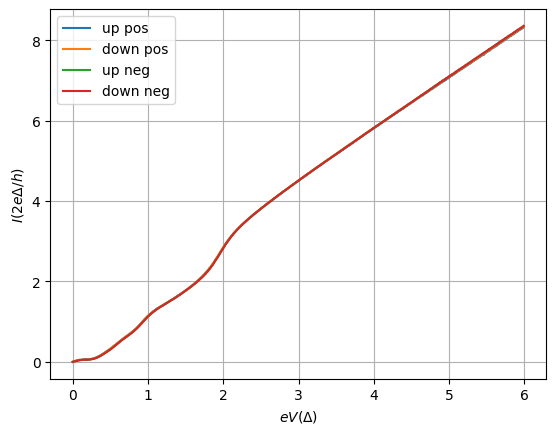

In [204]:
plt.close(4)
plt.figure(4)
plt.plot(V_norm, I_norm_up_pos,   label='up pos')
plt.plot(V_norm, I_norm_down_pos, label='down pos')
plt.plot(V_norm, I_norm_up_neg,   label='up neg')
plt.plot(V_norm, I_norm_down_neg, label='down neg')
plt.grid()
plt.legend()
plt.xlabel(r'$eV (\Delta$)')
plt.ylabel(r'$I (2e\Delta/h$)')

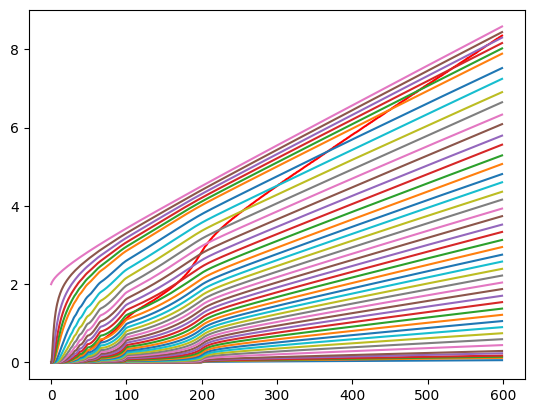

In [205]:
plt.plot(I_norm_down_neg,'r')
for i, t in enumerate(Transmission):
    plt.plot(I_norm_theo[i,:])

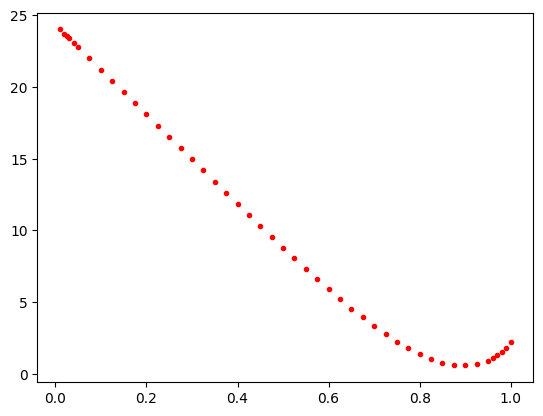

In [206]:
for i, t in enumerate(Transmission):
    plt.plot(t,np.mean((I_norm_up_pos-I_norm_theo[i,:])**2),'r.')

In [273]:
def get_theo_curves():
    arr = os.listdir('CarlosIV')
    arr.remove('iv.in')
    arr.remove('iv.for')

    Transmission = np.zeros(len(arr), dtype='float64')
    V_theo = np.linspace(0, 5.99, 600)
    I_theo = np.zeros((len(Transmission), len(V_theo)), dtype='float64')

    for i in range(len(arr)):
        temp = arr[i][:-4]
        value = int(temp)*10**(-len(temp)+1)
        Transmission[i] = value

    for i, a in enumerate(arr):
        v_theo = np.genfromtxt(f'CarlosIV/{a}')[:,0]
        i_theo = np.genfromtxt(f'CarlosIV/{a}')[:,1]
        I_theo[i,:] = bin_y_over_x(v_theo, i_theo, V_theo)
    dI_dV_theo = np.gradient(I_norm_theo, V_theo, axis=1)
    return V_theo, I_theo, dI_dV_theo, Transmission


def plot_theo_curves(V_theo, I_theo, dI_dV_theo, Transmission):
    plt.figure(1, figsize=(6,3))
    for i, T in enumerate(Transmission):
        plt.plot(V_theo, I_theo[i,:], '.',label=f'{T:0.03}')
    plt.grid()
    plt.xlim(0,2.5)
    plt.ylim(0,5.1)
    plt.xlabel(r'$V\ (\Delta/e)$')
    plt.ylabel(r'$I\ (2e\Delta/h)$')

    plt.figure(2, figsize=(6,3))
    for i, T in enumerate(Transmission):
        plt.plot(V_theo, dI_dV_theo[i,:], '.',label=f'{T:0.03}')
    plt.grid()
    plt.xlim(0,2.5)
    plt.ylim(0,8)
    plt.xlabel(r'$V\ (\Delta/e)$')
    plt.ylabel(r'd$I/$d$V\ (G_0)$')


def fake_fit(Transmission, I_theo, I_exp):    
    T_len = len(Transmission)
    MSD = []
    indices = []
    for i in range(T_len):
        for j in range(T_len-i):
            j = j+i
            for k in range(T_len-j):
                k=k+j
                I_theo_temp = I_theo[i,:] + I_theo[j,:] + I_theo[k,:]
                MSD.append(np.mean((I_exp-I_theo_temp)**2))
                indices.append([i,j,k])
    MSD = np.array(MSD, dtype='float64')
    indices = np.array(indices, dtype='int8')

    argmin = np.argmin(MSD)

    transmissions = Transmission[indices[argmin]]
    I_fitted = I_theo[indices[argmin][0],:] + I_theo[indices[argmin][1],:] + I_theo[indices[argmin][2],:]

    return MSD, indices, transmissions, I_fitted

%matplotlib qt

V_theo, I_theo, dI_dV_theo, Transmission = get_theo_curves()
# plot_theo_curves(V_theo, I_theo, dI_dV_theo, Transmission)
MSD, indices, transmissions, I_fitted = fake_fit(Transmission=Transmission, I_theo=I_norm_theo, I_exp=I_norm_up_pos)
plt.plot(np.gradient(I_norm_up_pos))
plt.plot(np.gradient(I_fitted))

In [223]:
T_len = len(Transmission)
MSD = np.zeros((T_len, T_len, T_len))

I_norms = [I_norm_up_pos, I_norm_up_neg, I_norm_down_pos, I_norm_down_neg]
MSDs = []
INDICES = []
TRANSMISSIONS = []
I_THEOS = []

for I_norm in I_norms:
    MSD = np.zeros((T_len, T_len, T_len))
    for i in range(T_len):
        for j in range(T_len):
            for k in range(T_len):
                I_theo = I_norm_theo[i,:] + I_norm_theo[j,:] + I_norm_theo[k,:]
                MSD[i,j,k] = np.mean((I_norm-I_theo)**2)

    indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
    transmissions = Transmission[indices]
    I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]
            
    MSDs.append(MSD)
    INDICES.append(indices)
    TRANSMISSIONS.append(transmissions)
    I_THEOS.append(I_theo)

# indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
# transmissions = Transmission[indices]
# I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]
TRANSMISSIONS

[array([0.175, 0.375, 0.675]),
 array([0.25 , 0.275, 0.7  ]),
 array([0.25 , 0.7  , 0.275]),
 array([0.01, 0.01, 0.01])]

In [224]:
%matplotlib qt
I_exps = [I_norm_up_pos, I_norm_up_neg, I_norm_down_pos, I_norm_down_neg]
for I in I_exps:
    plt.plot(I)

for i in range(4):
    plt.plot(I_THEOS[i])

In [48]:
T_len = len(Transmission)
MSD = np.zeros((T_len, T_len, T_len))

z=0
for i in range(T_len):
    for j in range(T_len):
        for k in range(T_len):
            I_theo = I_norm_theo[i,:] + I_norm_theo[j,:] + I_norm_theo[k,:]
            MSD[i,j,k] = np.mean((I_norm_down-I_theo)**2)
            
indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
transmissions = Transmission[indices]
I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]

In [232]:
T_len = len(Transmission)
MSD = np.zeros((T_len, T_len, T_len))

dIdV_exp = dIdV_norm_down_neg

for i in range(T_len):
    for j in range(T_len):
        for k in range(T_len):
            dIdV_theo = dIdV_norm_theo[i,:] + dIdV_norm_theo[j,:] + dIdV_norm_theo[k,:]
            MSD[i,j,k] = np.mean((dIdV_exp-dIdV_theo)**2)

indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len)))
transmissions = Transmission[indices]
I_theo = I_norm_theo[indices[0],:] + I_norm_theo[indices[1],:] + I_norm_theo[indices[2],:]
transmissions

array([0.2 , 0.25, 0.7 ])

In [49]:
plt.close(6)
plt.figure(6)
plt.plot(V_norm, I_theo, label=f'theo with t = {transmissions}')
plt.plot(V_norm, I_norm_down, label='exp')
plt.grid()
plt.legend()
plt.xlabel(r'$eV (\Delta)$')
plt.ylabel(r'$I (2e\Delta/h$)')

Text(0, 0.5, '$I (2e\\Delta/h$)')

Text(0, 0.5, '$dI/dV (G_0)$')

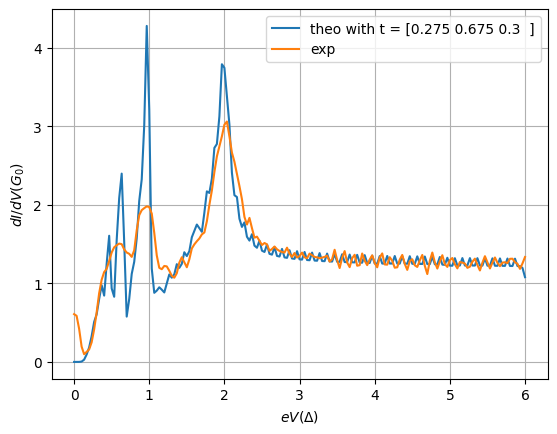

In [352]:
plt.close(7)
plt.figure(7)
plt.plot(V_norm, np.gradient(I_theo, V_norm), label=f'theo with t = {transmissions}')
plt.plot(V_norm, np.gradient(I_norm_down, V_norm), label='exp')
plt.grid()
plt.legend()
plt.xlabel(r'$eV (\Delta)$')
plt.ylabel(r'$dI/dV (G_0)$')

In [345]:
T_len = len(Transmission)
MSD = np.zeros((10000000, 6), dtype='int8')

z=0
for i in range(T_len):
    for j in range(T_len-i):
        j=i+j+1
        for k in range(T_len -j):
            k = k + j
            for l in range(T_len):
                for m in range(T_len):
                    for n in range(T_len):
                        I_theo = I_norm_theo[i,:] + I_norm_theo[j,:] + I_norm_theo[k,:]
                        I_theo = I_theo + I_norm_theo[l,:] + I_norm_theo[m,:] + I_norm_theo[n,:]
                        MSD[i,j,k,l,m,n] = np.mean((I_norm_down-I_theo)**2)
            
indices = np.array(np.unravel_index(np.argmin(MSD), (T_len, T_len, T_len, T_len, T_len, T_len)))
transmissions = Transmission[indices]
I_theo = I_norm_theo[0,:] + I_norm_theo[1,:] + I_norm_theo[2,:]
I_theo = I_theo + I_norm_theo[3,:] + I_norm_theo[4,:] + I_norm_theo[5,:]

IndexError: too many indices for array: array is 2-dimensional, but 6 were indexed

In [342]:

I_norm_down_mesh, _ = np.meshgrid(I_norm_down, Transmission)
I_norm_up_mesh, _ = np.meshgrid(I_norm_up, Transmission)

msd_down = np.mean((I_norm_down_mesh-I_norm_theo)**2, axis=1)
msd_up = np.mean((I_norm_up_mesh-I_norm_theo)**2, axis=1)


plt.plot(Transmission, msd_down, '.')
plt.plot(Transmission, msd_up, '.')

Transmission[np.argmin(msd_down)], Transmission[np.argmin(msd_up)]

7731052560

Text(0, 0.5, '$I (2e\\Delta/h$)')

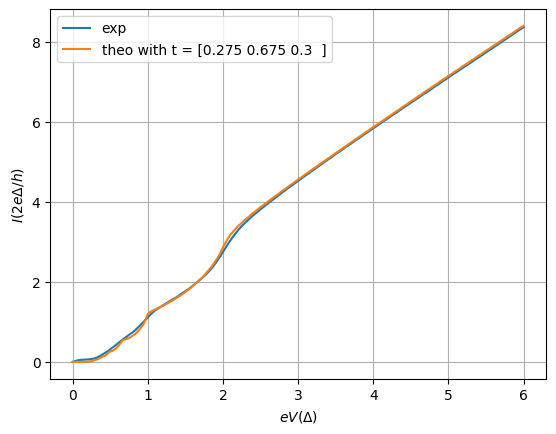